<a href="https://colab.research.google.com/github/AbiXnash/Sales-Prediction-Regression/blob/main/Sales_Prediction_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
data = pd.read_csv("train.csv")
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
data.shape

(913000, 4)

In [ ]:
data = data.drop(['store', 'item'], axis = 1)

In [ ]:
data['date'] = pd.to_datetime(data['date'])

In [ ]:
data['date'] = data['date'].dt.to_period("M")
monthly_sales = data.groupby('date').sum().reset_index()

In [ ]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [ ]:
monthly_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


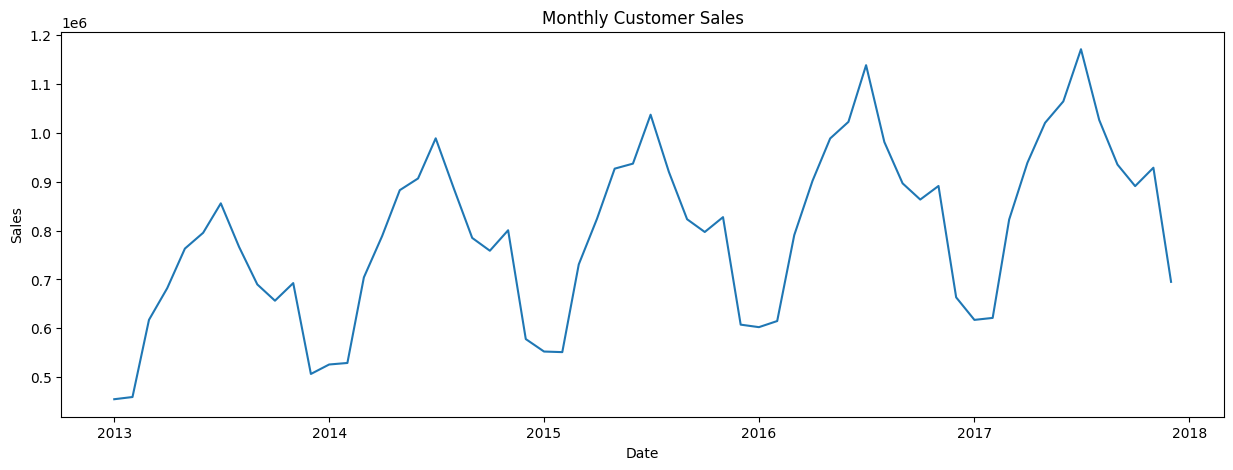

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales')
plt.show()

In [ ]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()

In [ ]:
monthly_sales.head()

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


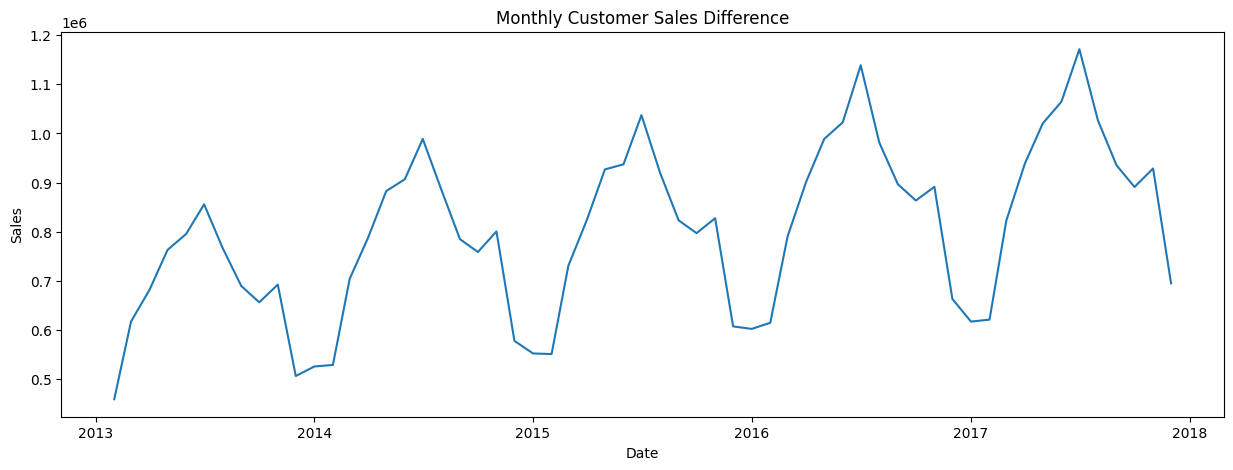

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales Difference')
plt.show()

In [ ]:
# xdata -> Supervised Data
xdata = monthly_sales.drop(['date', 'sales'], axis = 1)

In [ ]:
for i in range(1, 13):
  col = 'month_' + str(i)
  xdata[col] = xdata['sales_diff'].shift(i)

xdata = xdata.dropna().reset_index(drop = True)
xdata.head()

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


In [ ]:
train = xdata[:-12]
test = xdata[-12:]

train.shape, test.shape

((35, 13), (12, 13))

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [ ]:
X_train, y_train = train[:, 1:], train[:, 0:1]
X_test, y_test = test[:, 1:], test[:, 0:1]

In [ ]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [ ]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop = True)
sales_dates

0    2017-01-01
1    2017-02-01
2    2017-03-01
3    2017-04-01
4    2017-05-01
5    2017-06-01
6    2017-07-01
7    2017-08-01
8    2017-09-01
9    2017-10-01
10   2017-11-01
11   2017-12-01
Name: date, dtype: datetime64[ns]

In [ ]:
predict_df = pd.DataFrame(sales_dates)

In [ ]:
act_sales = monthly_sales['sales'][-13:].to_list()
act_sales

[663411,
 617306,
 621369,
 822667,
 938862,
 1020686,
 1064624,
 1171393,
 1026403,
 935263,
 891160,
 928837,
 695170]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
rf_pred = rf_model.predict(X_test)

In [ ]:
rf_pred = rf_pred.reshape(-1, 1)
rf_pred_test_set = np.concatenate([rf_pred, X_test], axis=1)

In [ ]:
rf_pred_test_set = scaler.inverse_transform(rf_pred_test_set)

In [ ]:
rf_result_list = []
for i in range(len(rf_pred_test_set)):
    rf_result_list.append(rf_pred_test_set[i][0] + act_sales[i])

In [ ]:
rf_pred_series = pd.Series(rf_result_list, name="Random Forest Prediction")

In [ ]:
predict_df = predict_df.merge(rf_pred_series, left_index=True, right_index=True)

In [ ]:
rf_mse = np.sqrt(mean_squared_error(predict_df['Random Forest Prediction'], monthly_sales['sales'][-12:]))
rf_mae = mean_absolute_error(predict_df['Random Forest Prediction'], monthly_sales['sales'][-12:])
rf_r2 = r2_score(predict_df['Random Forest Prediction'], monthly_sales['sales'][-12:])

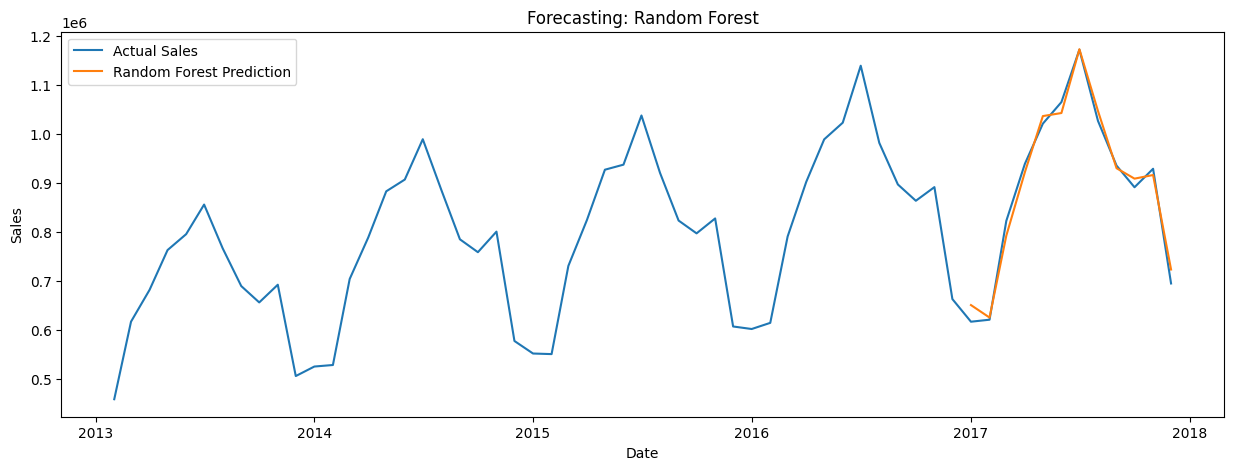

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'], label='Actual Sales')
plt.plot(predict_df['date'], predict_df['Random Forest Prediction'], label='Random Forest Prediction')
plt.title('Forecasting: Random Forest')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
# Display metrics
print("Random Forest Metrics:")
print("RMSE:", rf_mse)
print("MAE:", rf_mae)
print("R^2 Score:", rf_r2)


Random Forest Metrics:
RMSE: 20024.281011094597
MAE: 17354.670000000002
R^2 Score: 0.9847646287619984
